## CHAAYA GIRIMON GH1027231
### PROBLEM STATEMENT:
The company is looking to enhance the recommendation system for women's clothing in their e-commerce website (Shaghayegh Shirkhani, et. al. (2023)). The accurate predictions can help in improving the company's targeted marketing strategies and customer satisfaction. This problem is formulated as a binary classification task where the clothing item is recommended based on the review and the age of the customer (Brownlee, J. (2020)).

### DATA COLLECTION:
The data can be found in this link: 
https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import demoji
import re
from nltk.tokenize import RegexpTokenizer  
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### DATA PREPROCESSING AND EXPLORATION:
- Rows without reviews are removed.
- Textual data(reviews) are cleaned:
    - Removing extra spaces, texts in brackets, URLs, and emojis.
    - Convert it to lowercase.
    - Removing stop words
    - Tokenize and lemmatize the text

In [3]:
df.shape

(23486, 11)

In [4]:
df.isnull().sum()

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [5]:
df.dropna(subset=['Review Text'], inplace =True)

In [6]:
def clean_text(text):
    tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+http\S+')
    stops = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = demoji.replace(text, '')  # Remove emojis
    text = text.lower()  # Convert to lowercase
    text = tokenizer.tokenize(text)
    text = [w for w in text if w not in stops]
    text = [lemmatizer.lemmatize(w) for w in text]
    return text

In [7]:
df['Review Text Tokenised'] = df['Review Text'].apply(clean_text)

In [8]:
df['Joined Review'] = df['Review Text Tokenised'].apply(lambda x: ' '.join(x))

In [9]:
train, test = train_test_split(df, test_size=0.2)

### EXPLORATORY DATA ANALYSIS

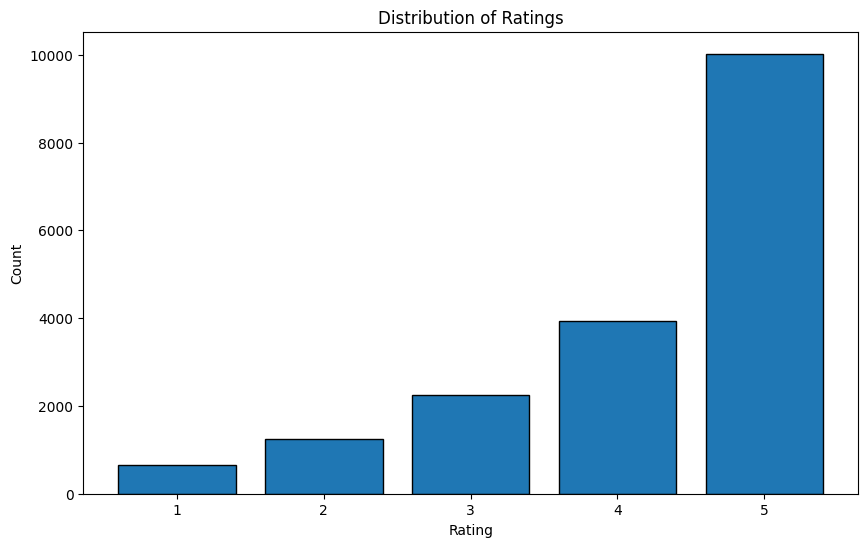

In [10]:
plt.figure(figsize=(10, 6))
ratings_counts = train['Rating'].value_counts().sort_index()
plt.bar(ratings_counts.index, ratings_counts.values, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1, 6))
plt.show()

The bar chart displays the distribution of product ratings in the dataset. The review scores range from 1 to 5.It shows that majority of the reviews were given a score of 5. Ratings of 1,2, and 3 are significantly less implying that there is a positive bias in the dataset.

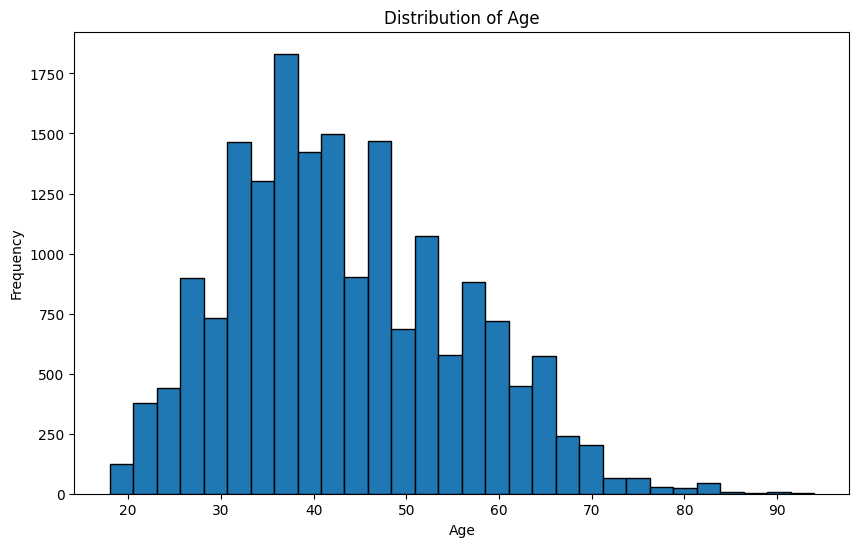

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(train['Age'], bins=30, edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

This Histogram shows the distribution of the age of reviewers.
The chart indicates that middle aged women (around the age range of 30-40) are the most common demographic of this company.

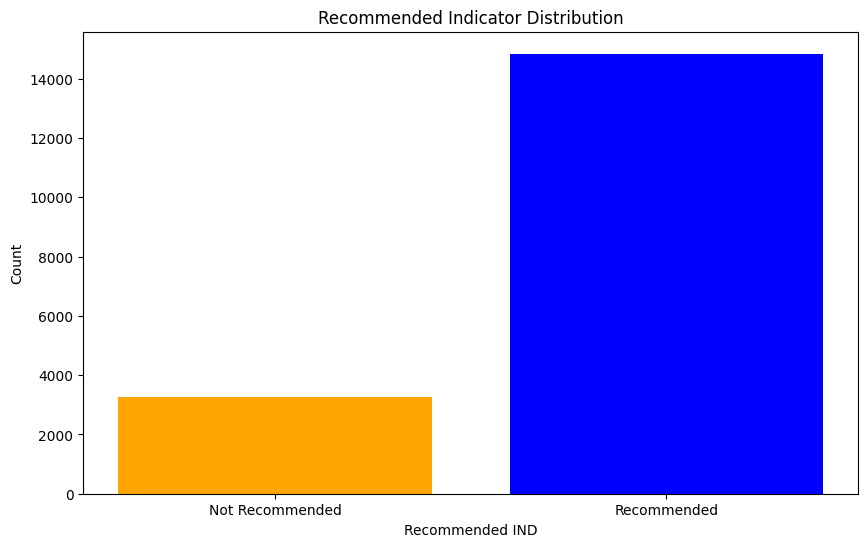

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(train['Recommended IND'].value_counts().index, train['Recommended IND'].value_counts(), color=['blue', 'orange'])
plt.title('Recommended Indicator Distribution')
plt.xlabel('Recommended IND')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Recommended', 'Recommended'])
plt.show()

This bar chart illustrates the distribution of the recommendations of the clothing items in the website where 0 means the item is not recommended and 1 means it is. The chart shows that majority of the products have been recommended, reinforcing the positive bias of the dataset.

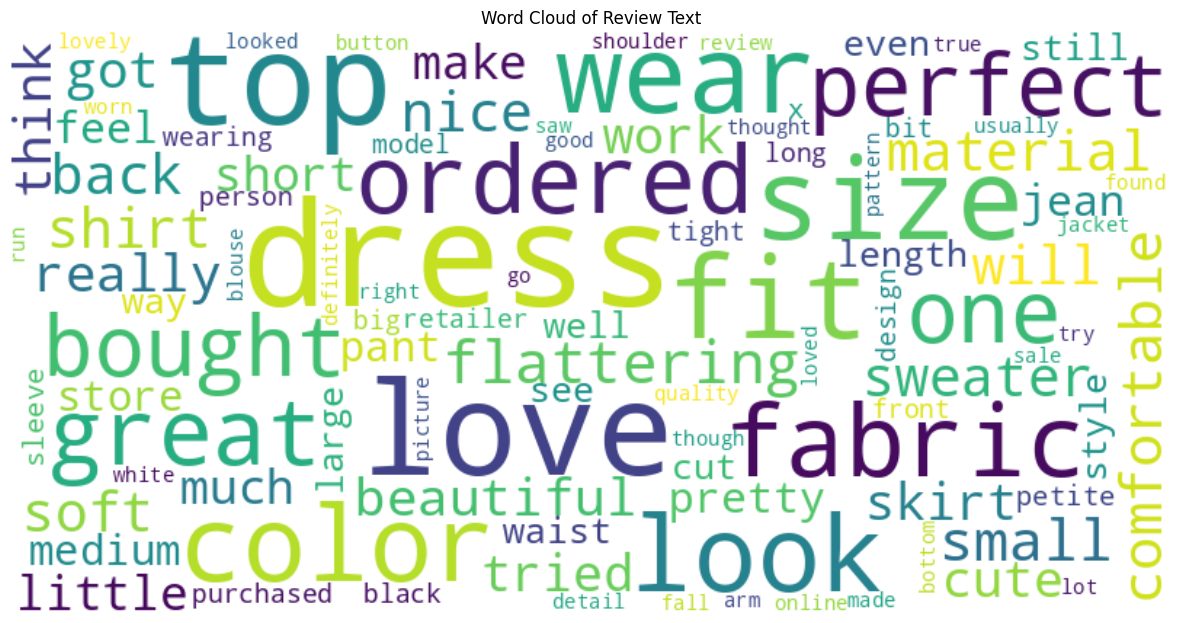

In [13]:
text = " ".join(review for review in train['Review Text'].dropna())
wordcloud = WordCloud(width=800, height=400, max_font_size=100, max_words=100, background_color="white").generate(text)

# Display the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud of Review Text')
plt.show()

The word cloud shows that words like "fit", "dress", "size", and love are used more frequently in the reviews, suggesting this to be frequent topics being discussed. This visualisatoin helps with understanding the sentiment of the consumers

/var/folders/_6/k19_kjb552v4gfyyb6dyg1n40000gn/T/ipykernel_6297/3957035046.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train.corr()


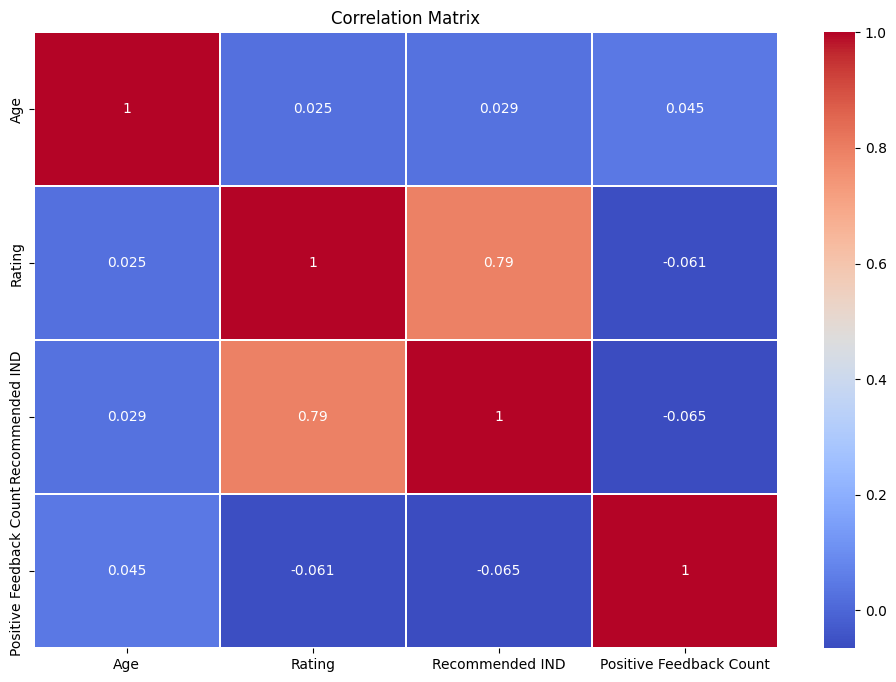

In [14]:
train.drop(['Unnamed: 0','Clothing ID'], axis=1, inplace=True)
plt.figure(figsize=(12, 8))
correlation_matrix = train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.2)
plt.title('Correlation Matrix')
plt.show()

This correlation matrix shows that Age the Rating have a positive correlation with the label (y - Recommend IND). Hence these variables will be used as features for the model including the text reviews.

### MODEL TRAINING:
The tokenised data is then combined using TF-IDF and the age and rating is scaled with the help of a pipeline. Custom tranformers are also created to extract the text and numeric columns (Chandra, H. (2020)). 

The Support Vector Machine (SVM) is selected for training (scikit learn (2018)). The optimal hyperparameters are chosen with the help of GridSearchCV (SciKit Learn (2019)). 

In [15]:
x_train = train[['Joined Review', 'Age', 'Rating']]
y_train = train['Recommended IND']
x_test = test[['Joined Review', 'Age', 'Rating']]
y_test = test['Recommended IND']

In [16]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.key]

This transformer selects the 'Joined Review' from the training set.
- \_\_init\_\_(self, key): Initializes the transformer with the key (column name) to select.
- fit(self, X, y=None): This method is required but does nothing in this case. It simply returns self.
- transform(self, X): This method extracts the specified column from the DataFrame.

In [17]:
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[[self.key]]

This tranformer selects the 'Age' column from the training set.
- \_\_init\_\_(self, key): Initializes the transformer with the key (column name) to select.
- fit(self, X, y=None): Similar to TextSelector, this method does nothing and returns self.
- transform(self, X): This method extracts the specified column from the DataFrame and returns it as a DataFrame.


In [18]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('selector', TextSelector(key='Joined Review')),
            ('tfidf', TfidfVectorizer())
        ])),
        ('age', Pipeline([
            ('selector', NumberSelector(key='Age')),
            ('scaler', StandardScaler())
        ])),
        ('rating', Pipeline([
            ('selector', NumberSelector(key='Rating')),
            ('scaler', StandardScaler())
        ]))
    ])),
    ('clf', svm.SVC())
])

In [19]:
param_grid = {
    'features__text__tfidf__max_df': [0.75, 1.0],
    'features__text__tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}

In [20]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

In [21]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('text',
                                                                        Pipeline(steps=[('selector',
                                                                                         TextSelector(key='Joined '
                                                                                                          'Review')),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer())])),
                                                                       ('age',
                                                                        Pipeline(steps=[('selector',
                                                                                         NumberSelector(key='Age')),
                                                                                        ('scaler',
                                                                                         StandardScaler())])),
                                                                       ('rating',
                                                                        Pipeline(steps=[('selector',
                                                                                         NumberSelector(key='Rating')),
                                                                                        ('scaler',
                                                                                         StandardScaler())]))])),
                                       ('clf', SVC())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__gamma': ['scale', 'auto'],
                         'clf__kernel': ['linear', 'rbf'],
                         'features__text__tfidf__max_df': [0.75, 1.0],
                         'features__text__tfidf__ngram_range': [(1, 1),
                                                                (1, 2)]},
             scoring='accuracy')

### MODEL ASSESSMENT
The model is evaluated using accuracy score and F1 score and visualised with the help of classification report. 

In [22]:
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Best parameters: {'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf', 'features__text__tfidf__max_df': 0.75, 'features__text__tfidf__ngram_range': (1, 1)}
Best cross-validation accuracy: 0.9419168411887181


In [23]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(x_test)

In [24]:
print(classification_report(y_test, predictions))
print('Accuracy score: ', round(accuracy_score(y_test, predictions), 2))
print('F1 score: ', round(f1_score(y_test, predictions), 2))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       836
           1       0.96      0.96      0.96      3693

    accuracy                           0.93      4529
   macro avg       0.90      0.88      0.89      4529
weighted avg       0.93      0.93      0.93      4529

Accuracy score:  0.93
F1 score:  0.96


In [28]:
def predict_recommendation(clothing_id):
    clothing_item = test[test['Clothing ID'] == clothing_id].iloc[0]
    review = clothing_item['Joined Review']
    age = clothing_item['Age']
    rating = clothing_item['Rating']
    
    sample = pd.DataFrame({'Joined Review': [review], 'Age': [age], 'Rating': [rating]})
    prediction = best_model.predict(sample)
    
    return 'Recommended' if prediction[0] == 1 else 'Not Recommended'

In [29]:
# example of recommending clothing item
example_clothing_id = test['Clothing ID'].iloc[0]
example_review = test['Review Text'].iloc[0]
recommendation = predict_recommendation(example_clothing_id)
print(f"Clothing ID: {example_clothing_id}\nReview: {example_review}\nRecommendation: {recommendation}")

Clothing ID: 1020
Review: The fabric is so beautiful that i am tempted to buy in a large size and have re-made. the waist is tiny. the hips are wide. when it goes to half price, i may be tempted to take it to my favorite alterations lady. the fabric is that exceptionally beautiful.
Recommendation: Recommended


### FINAL DISCUSSIONS:
The model has an accuracy of 93% which is a decent score. This demonstrates the use of text and numeric featurres in predicting product recommmendations. However there are a few disadvantages which is that the dataset is imbalanced (more positive than negative) and possible overfitting.

Improved product recommendations can lead to better customer satisfaction and retention. Insights from the customer reviews and the demographics can help in targeted marketing.

### RECOMMENDATIONS
- Collect more data for balanced dataset and to mitigate potential biases.
- Use the model to identify key segments of customers who are likely to recommend products and tailor marketing campaigns to them.

### REFERENCES:
Shaghayegh Shirkhani, Hamam Mokayed, Saini, R. and Hum Yan Chai (2023). Study of AI-Driven Fashion Recommender Systems. SN Computer Science, 4(5). doi:https://doi.org/10.1007/s42979-023-01932-9.

Brownlee, J. (2020). 4 Types of Classification Tasks in Machine Learning. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/types-of-classification-in-machine-learning/.

Chandra, H. (2020). Pipelines & Custom Transformers in scikit-learn: The step-by-step guide (with Python code). [online] Medium. Available at: https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156 [Accessed 9 Jul. 2024].

scikit learn (2018). 1.4. Support Vector Machines — scikit-learn 0.20.3 documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/svm.html.


SciKit Learn (2019). sklearn.model_selection.GridSearchCV — scikit-learn 0.22 Documentation. [online] Scikit-learn.org. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.